 # Setup

In [1]:
import os
import pickle
import torch
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
import torchvision.transforms.functional as VF
from pycocotools.coco import COCO
import torchvision.transforms.v2 as T
import torch.nn as nn
from torchvision.models import resnet18
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision
from torchvision.ops import box_iou
import matplotlib.pyplot as plt
from itertools import cycle
from tqdm.notebook import tqdm
import random
import numpy as np
import wandb
from PIL import Image
import torchvision.transforms as transforms


In [2]:
wandb.login()


wandb: Currently logged in as: fejowo5522 (fejowo5522-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# reduce cpu contention
torch.set_num_threads(6)
# NUM_WORKERS = 6  # adjust based on CPU cores


cuda


In [4]:
COCO_PATH = "../../data/coco/"  # change this
IMG_DIR_TRAIN = os.path.join(COCO_PATH, "images/train2017")
IMG_DIR_VAL = os.path.join(COCO_PATH, "images/val2017")
ANN_FILE_TRAIN = os.path.join(COCO_PATH, "annotations/person_keypoints_train2017.json")
ANN_FILE_VAL = os.path.join(COCO_PATH, "annotations/person_keypoints_val2017.json")

REMOVE_IMAGES_WITHOUT_KEYPOINTS = True
VAL_SPLIT = 0.5
TEST_VAL_TRAIN_PERCENT = (1, 1, 1)
BATCH_SIZE = 128
DATA_AUGMENTATION = True
NUM_KEYPOINTS = 17

# New constants for person detector
DETECTION_THRESHOLD = 0.8
IOU_THRESHOLD = 0.5
CROP_SIZE = 256


 # Data Preparation with Person Detector

In [5]:
class CocoPersonCropsDataset(torch.utils.data.Dataset):
    def __init__(self, img_folder, ann_file, transform=None, 
                 detection_thresh=DETECTION_THRESHOLD, iou_thresh=IOU_THRESHOLD,
                 cache_file="detections_cache.pkl", img_ids=None):
        self.root = img_folder
        self.coco = COCO(ann_file)
        self.transform = transform
        self.detection_thresh = detection_thresh
        self.iou_thresh = iou_thresh
        
        # Load or compute detections
        if os.path.exists(cache_file):
            print(f"Loading detections from cache: {cache_file}")
            with open(cache_file, 'rb') as f:
                self.detections = pickle.load(f)
        else:
            print("Precomputing detections...")
            self.detections = self._precompute_detections(cache_file)
        # Filter for images with detections
        self.img_ids = list(self.detections.keys())
        if img_ids is not None:
            self.img_ids = [img_id for img_id in self.img_ids if img_id in img_ids]

        # Build sample list (image_id, detection_idx), filter out boxes without keypoints
        self.samples = []
        for img_id in self.img_ids:
            for det_idx, (box, keypoints) in enumerate(self.detections[img_id]):
                keypoints_arr = np.array(keypoints).reshape(-1, 3)
                # At least one visible keypoint (v > 0)
                if np.any(keypoints_arr[:, 2] > 0):
                    self.samples.append((img_id, det_idx))
        
    def _precompute_detections(self, cache_file):
        # Load detector model
        detector = fasterrcnn_resnet50_fpn(pretrained=True)
        detector.eval()
        detector.to(device)
        
        detections_dict = {}
        transform = T.Compose([T.ToTensor()])
        
        for img_id in tqdm(self.coco.imgs):
            img_info = self.coco.loadImgs(img_id)[0]
            img_path = os.path.join(self.root, img_info['file_name'])
            img = Image.open(img_path).convert('RGB')
            
            # Get annotations for this image
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            annotations = self.coco.loadAnns(ann_ids)
            person_anns = [ann for ann in annotations if ann['category_id'] == 1]
            
            # Run detector
            img_tensor = transform(img).unsqueeze(0).to(device)
            with torch.no_grad():
                detections = detector(img_tensor)[0]
            
            # Filter detections
            keep = (detections['labels'] == 1) & (detections['scores'] > self.detection_thresh)
            boxes = detections['boxes'][keep].cpu().numpy()
            scores = detections['scores'][keep].cpu().numpy()
            
            # Match detections with ground truth
            matched_detections = []
            for box in boxes:
                best_iou = self.iou_thresh
                best_ann = None
                
                for ann in person_anns:
                    # Convert COCO bbox format [x,y,w,h] to [x1,y1,x2,y2]
                    gt_box = ann['bbox']
                    gt_box = torch.tensor([
                        gt_box[0], gt_box[1], 
                        gt_box[0] + gt_box[2], 
                        gt_box[1] + gt_box[3]
                    ]).unsqueeze(0)
                    
                    # Calculate IoU
                    iou = box_iou(torch.tensor([box]), gt_box).item()
                    if iou > best_iou:
                        best_iou = iou
                        best_ann = ann
                
                if best_ann is not None:
                    matched_detections.append((box, best_ann['keypoints']))
            
            detections_dict[img_id] = matched_detections
        
        # Save cache
        with open(cache_file, 'wb') as f:
            pickle.dump(detections_dict, f)
        
        return detections_dict
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_id, det_idx = self.samples[idx]
        box, keypoints = self.detections[img_id][det_idx]
        
        # Load image
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(img_path).convert('RGB')
        
        # Convert box to integers
        x1, y1, x2, y2 = map(int, box)
        w, h = img.size
        
        # Ensure box is within image bounds
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)
        box_w = x2 - x1
        box_h = y2 - y1
        
        # Skip invalid boxes
        if box_w <= 0 or box_h <= 0:
            crop = Image.new('RGB', (CROP_SIZE, CROP_SIZE), (0, 0, 0))
            keypoints_tensor = torch.zeros((NUM_KEYPOINTS, 3), dtype=torch.float32)
            return self.transform(crop), keypoints_tensor
        
        # Crop and resize
        crop = img.crop((x1, y1, x2, y2))
        crop = crop.resize((CROP_SIZE, CROP_SIZE))
        
        # Adjust keypoints to crop
        keypoints = np.array(keypoints).reshape(-1, 3)
        adjusted_keypoints = []
        
        for kp in keypoints:
            x, y, v = kp
            # Only adjust visible keypoints within the crop
            if v > 0 and x1 <= x <= x2 and y1 <= y <= y2:
                new_x = (x - x1) * (CROP_SIZE / box_w)
                new_y = (y - y1) * (CROP_SIZE / box_h)
                # Set visibility to 0 if outside crop
                if 0 <= new_x <= CROP_SIZE and 0 <= new_y <= CROP_SIZE:
                    adjusted_keypoints.append([new_x, new_y, 1])
                    continue
            adjusted_keypoints.append([0, 0, 0])
        
        keypoints_tensor = torch.tensor(adjusted_keypoints, dtype=torch.float32)
        
        if self.transform:
            crop = self.transform(crop)
            
        return crop, keypoints_tensor


In [6]:
# Custom transform for cropped images
class CropTransform:
    def __init__(self, augmentation=False):
        if augmentation:
            self.transform = transforms.Compose([
                transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
                transforms.RandomApply([transforms.RandomGrayscale(p=1.0)], p=0.2),
                transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
    
    def __call__(self, img):
        return self.transform(img)


In [7]:
# Create datasets
train_crop_dataset = CocoPersonCropsDataset(
    IMG_DIR_TRAIN, 
    ANN_FILE_TRAIN, 
    transform=CropTransform(augmentation=DATA_AUGMENTATION),
    cache_file="train_detections.pkl"
)

val_crop_dataset = CocoPersonCropsDataset(
    IMG_DIR_VAL, 
    ANN_FILE_VAL, 
    transform=CropTransform(augmentation=False),
    cache_file="val_detections.pkl"
)

# Split validation into val and test
val_size = int(VAL_SPLIT * len(val_crop_dataset))
test_size = len(val_crop_dataset) - val_size
val_dataset, test_dataset = random_split(val_crop_dataset, [val_size, test_size])

# Create subsets
subset_len_train = int(TEST_VAL_TRAIN_PERCENT[0] * len(train_crop_dataset))
subset_len_val = int(TEST_VAL_TRAIN_PERCENT[1] * len(val_dataset))
subset_len_test = int(TEST_VAL_TRAIN_PERCENT[2] * len(test_dataset))

train_dataset = torch.utils.data.Subset(train_crop_dataset, range(subset_len_train))
val_dataset = torch.utils.data.Subset(val_dataset, range(subset_len_val))
test_dataset = torch.utils.data.Subset(test_dataset, range(subset_len_test))


loading annotations into memory...
Done (t=5.77s)
creating index...
index created!
Loading detections from cache: train_detections.pkl
loading annotations into memory...
Done (t=0.31s)
creating index...
index created!
Loading detections from cache: val_detections.pkl


In [8]:
# Create dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    pin_memory=True
)


In [9]:
print("Train dataset size:", len(train_dataset))
print("Val dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))


Train dataset size: 137685
Val dataset size: 2807
Test dataset size: 2807


 ## Visualize Cropped Data

In [7]:
def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img_tensor * std + mean

def visualize_crop_prediction(img_tensor, keypoints_tensor, pred_keypoints=None):
    img = unnormalize(img_tensor).permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
    
    # Plot GT keypoints
    for i, kp in enumerate(keypoints_tensor):
        if kp[2] > 0.5:  # Only plot visible keypoints
            plt.scatter(kp[0], kp[1], color='red', marker='o', s=20, label='GT' if i==0 else None)
    
    # Plot predicted keypoints
    if pred_keypoints is not None:
        for i, kp in enumerate(pred_keypoints):
            if kp[2] > 0.5:  # Confidence threshold
                plt.scatter(kp[0], kp[1], color='green', marker='x', s=50, label='Pred' if i==0 else None)
    
    plt.legend()
    plt.show()


Keypoints: tensor([[  0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000],
        [158.7200,  21.5579,   1.0000],
        [  0.0000,   0.0000,   0.0000],
        [163.8400,  53.8947,   1.0000],
        [ 30.7200,  53.8947,   1.0000],
        [189.4400,  97.0105,   1.0000],
        [ 25.6000,  87.5789,   1.0000],
        [235.5200, 122.6105,   1.0000],
        [  0.0000,   0.0000,   0.0000],
        [143.3600, 122.6105,   1.0000],
        [ 56.3200, 121.2632,   1.0000],
        [128.0000, 184.5895,   1.0000],
        [ 61.4400, 183.2421,   1.0000],
        [128.0000, 242.5263,   1.0000],
        [ 66.5600, 237.1368,   1.0000]])


C:\Users\patry\AppData\Local\Temp\ipykernel_7648\1566568707.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


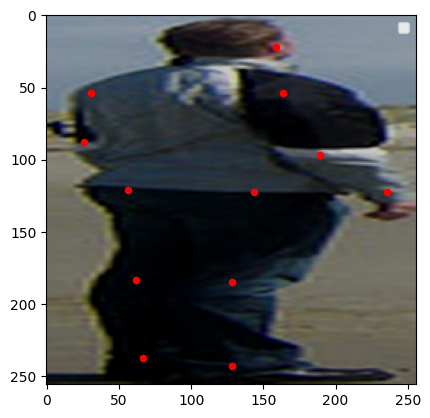

In [11]:
# Test visualization
sample_idx = random.randint(0, len(train_dataset)-1)
img, kps = train_dataset[sample_idx]

print("Keypoints:", kps)
visualize_crop_prediction(img, kps)


 # Keypoint Model for Cropped Persons

In [8]:
class KeypointCropModel(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Remove avgpool and fc
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, NUM_KEYPOINTS * 3)  # Predict x, y, confidence for each keypoint
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = x.view(-1, NUM_KEYPOINTS, 3)
        return x


In [13]:
model = KeypointCropModel().to(device)
print(model)


c:\Users\patry\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\patry\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeypointCropModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

 # Training Setup

In [14]:
def keypoint_crop_loss(preds, targets):
    # Coordinate loss (only for visible keypoints)
    coord_mask = (targets[..., 2] > 0)  # Visibility mask
    coord_loss = F.smooth_l1_loss(
        preds[..., :2][coord_mask],
        targets[..., :2][coord_mask],
        reduction='sum'
    ) / (coord_mask.sum() + 1e-8)
    
    # Confidence loss (BCE)
    conf_loss = F.binary_cross_entropy_with_logits(
        preds[..., 2],
        targets[..., 2],
        reduction='mean'
    )
    
    return coord_loss + conf_loss


In [15]:
EPOCHS = 200
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4

criterion = keypoint_crop_loss
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)


In [16]:
wandb_config = {
    "epochs": EPOCHS,
    "learning_rate": LEARNING_RATE,
    "weight_decay": WEIGHT_DECAY,
    "batch_size": BATCH_SIZE,
    "train_size": len(train_dataset),
    "val_size": len(val_dataset),
    "test_size": len(test_dataset),
    "model": "KeypointCropModel",
    "criterion": "SmoothL1+BCE",
    "optimizer": "Adam",
    "num_keypoints": NUM_KEYPOINTS,
    "crop_size": CROP_SIZE,
    "detection_threshold": DETECTION_THRESHOLD,
    "iou_threshold": IOU_THRESHOLD,
    "device": device,
    "data_augmentation": DATA_AUGMENTATION
}

wandb.init(
    entity="fejowo5522-",
    project="NN_Project",
    config=wandb_config,
    group="KeypointDetectionWithDetector"
)


 # Training Loop

In [17]:
def train_one_epoch(model, dataloader, optimizer, criterion, verbose_tqdm=False):
    model.train()
    total_loss = 0.0

    dl = tqdm(dataloader, desc="Training") if verbose_tqdm else dataloader    
    for imgs, keypoints in dl:
        imgs = imgs.to(device)
        keypoints = keypoints.to(device)
        
        optimizer.zero_grad()
        
        preds = model(imgs)
        loss = criterion(preds, keypoints)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, verbose_tqdm=False):
    model.eval()
    total_loss = 0.0

    dl = tqdm(dataloader, desc="Evaluating") if verbose_tqdm else dataloader
    with torch.no_grad():
        for imgs, keypoints in dl:
            imgs = imgs.to(device)
            keypoints = keypoints.to(device)
            
            preds = model(imgs)
            loss = criterion(preds, keypoints)
            
            total_loss += loss.item()
    
    return total_loss / len(dataloader)


In [ ]:
verbose_tqdm = False
early_stopping = True
patience = 20
best_val_loss = float('inf')
epochs_no_improve = 0

train_losses = []
val_losses = []


In [18]:
for epoch in tqdm(range(EPOCHS)):
    # print(f"Epoch {epoch+1}/{EPOCHS}")
    
    # Train
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, verbose_tqdm=verbose_tqdm)
    train_losses.append(train_loss)
    
    # Validate
    val_loss = evaluate(model, val_loader, criterion, verbose_tqdm=verbose_tqdm)
    val_losses.append(val_loss)
    
    # print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Log to wandb
    wandb.log({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'val_loss': val_loss
    })
    
    # Early stopping
    if early_stopping:
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break


  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [19]:
# Load best model
model.load_state_dict(torch.load("best_model.pth"))

# Evaluate on test set
test_loss = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")

# Log test results
wandb.log({'test_loss': test_loss})
wandb.finish()

# Save final model
torch.save(model.state_dict(), "keypoint_crop_model.pth")
print("Model saved to keypoint_crop_model.pth")


Test Loss: 23.7582


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
test_loss,▁
train_loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,33
test_loss,23.75816
train_loss,14.89542
val_loss,23.68605


Model saved to keypoint_crop_model.pth


 # Visualization of Results

In [20]:
def visualize_results(model, dataset, num_samples=3):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)
    
    for idx in indices:
        img, gt_kps = dataset[idx]
        img_tensor = img.unsqueeze(0).to(device)
        
        with torch.no_grad():
            pred_kps = model(img_tensor)[0].cpu()
        
        # Apply sigmoid to confidence
        pred_kps[:, 2] = torch.sigmoid(pred_kps[:, 2])
        
        print(f"Sample {idx+1}")
        visualize_crop_prediction(img, gt_kps, pred_kps)


Sample 2103


C:\Users\patry\AppData\Local\Temp\ipykernel_7648\1566568707.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


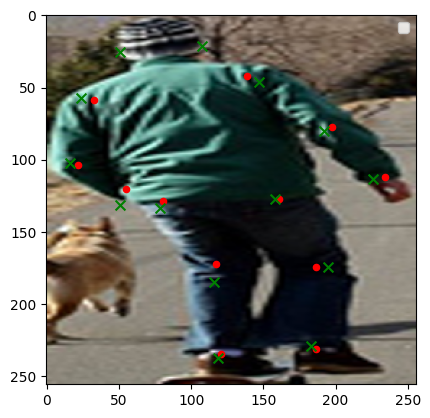

Sample 1954


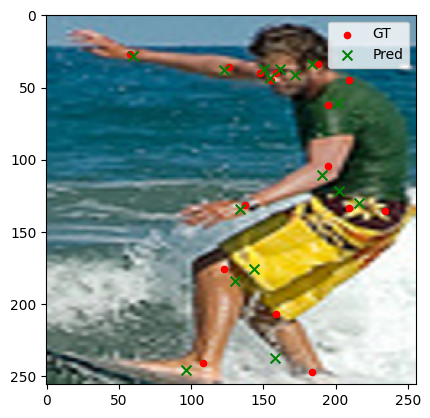

Sample 748


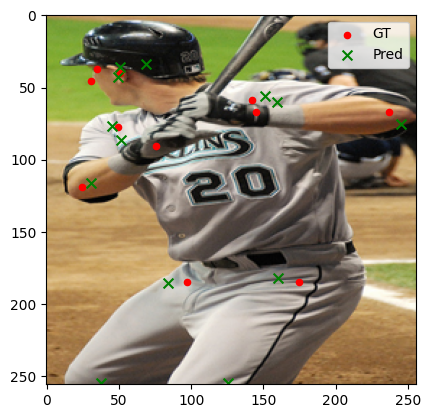

In [23]:
visualize_results(model, test_dataset, num_samples=3)


 # Training Curves

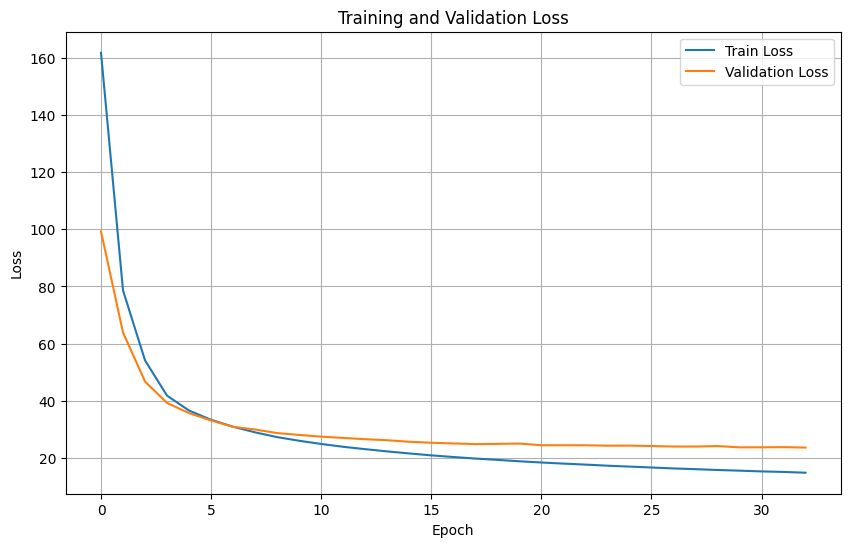

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_curves.png')
plt.show()

# Test model on real example

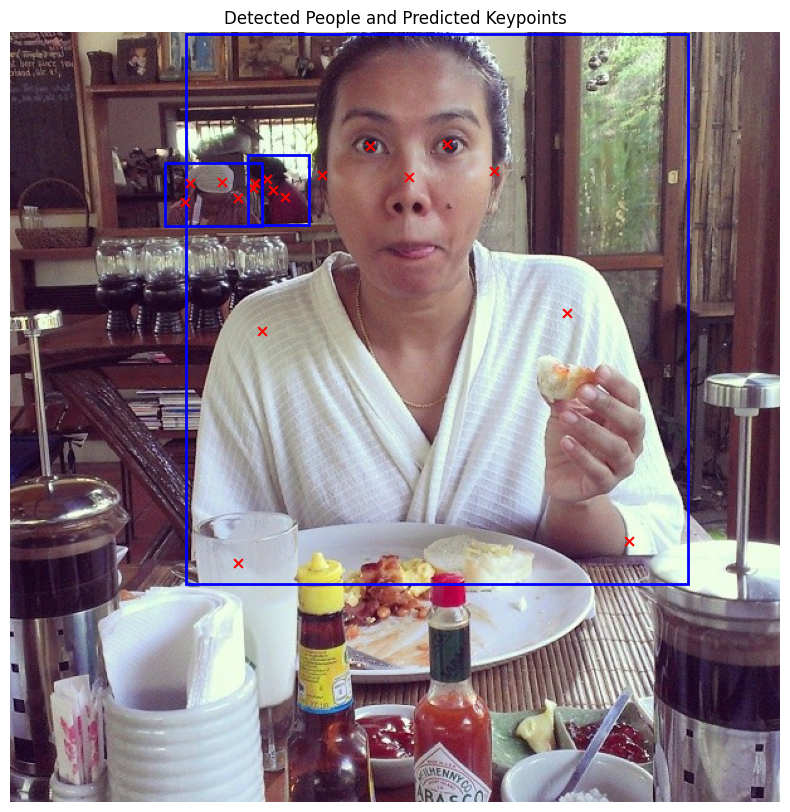

In [19]:
# Load the trained keypoint model
model = KeypointCropModel().to(device)
model.load_state_dict(torch.load("../../models/bb_23loss_keypoint_crop_model.pth"))
model.eval()

# Load a fresh image
fresh_img_path = os.path.join(IMG_DIR_VAL, random.choice(os.listdir(IMG_DIR_VAL)))
fresh_img = Image.open(fresh_img_path).convert('RGB')

# Load person bb detector
detector = fasterrcnn_resnet50_fpn(pretrained=True).to(device)
detector.eval()

# Detect people bbx's
transform = T.Compose([T.ToTensor()])
img_tensor = transform(fresh_img).unsqueeze(0).to(device)
with torch.no_grad():
    detections = detector(img_tensor)[0]

# Filter detections for persons with high confidence
person_mask = (detections['labels'] == 1) & (detections['scores'] > DETECTION_THRESHOLD)
boxes = detections['boxes'][person_mask].cpu().numpy()
scores = detections['scores'][person_mask].cpu().numpy()

# For each detected person, crop, resize, and predict keypoints
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(fresh_img)
for box in boxes:
    x1, y1, x2, y2 = map(int, box)
    crop = fresh_img.crop((x1, y1, x2, y2)).resize((CROP_SIZE, CROP_SIZE))
    crop_tensor = CropTransform(augmentation=False)(crop).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_kps = model(crop_tensor)[0].cpu()
    pred_kps[:, 2] = torch.sigmoid(pred_kps[:, 2])

    # Map keypoints back to original image coordinates
    box_w, box_h = x2 - x1, y2 - y1
    for kp in pred_kps:
        if kp[2] > 0.5:
            orig_x = kp[0] * (box_w / CROP_SIZE) + x1
            orig_y = kp[1] * (box_h / CROP_SIZE) + y1
            ax.scatter(orig_x, orig_y, color='red', marker='x', s=40)
    # Draw bounding box
    rect = plt.Rectangle((x1, y1), box_w, box_h, fill=False, edgecolor='blue', linewidth=2)
    ax.add_patch(rect)

plt.title("Detected People and Predicted Keypoints")
plt.axis('off')
plt.show()

# Create and save model pipeline

In [35]:
class PersonKeypointPipeline:
    def __init__(self, detector, keypoint_model, crop_transform, device='cpu', detection_threshold=0.8, crop_size=256):
        self.detector = detector.to(device)
        self.detector.eval()
        self.keypoint_model = keypoint_model.to(device)
        self.keypoint_model.eval()
        self.crop_transform = crop_transform
        self.device = device
        self.detection_threshold = detection_threshold
        self.crop_size = crop_size

    def predict(self, pil_img):
        """
        Args:
            pil_img: PIL.Image.Image, RGB image

        Returns:
            List of dicts, each with:
                - 'box': [x1, y1, x2, y2]
                - 'keypoints': np.ndarray of shape (NUM_KEYPOINTS, 3)
        """
        # Detect people
        img_tensor = T.Compose([T.ToTensor()])(pil_img).unsqueeze(0).to(self.device)
        with torch.no_grad():
            detections = self.detector(img_tensor)[0]

        person_mask = (detections['labels'] == 1) & (detections['scores'] > self.detection_threshold)
        boxes = detections['boxes'][person_mask].cpu().numpy()

        results = []
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            crop = pil_img.crop((x1, y1, x2, y2)).resize((self.crop_size, self.crop_size))
            crop_tensor = self.crop_transform(crop).unsqueeze(0).to(self.device)
            with torch.no_grad():
                pred_kps = self.keypoint_model(crop_tensor)[0].cpu()
            pred_kps[:, 2] = torch.sigmoid(pred_kps[:, 2])

            # Map keypoints back to original image coordinates
            box_w, box_h = x2 - x1, y2 - y1
            mapped_kps = []
            for kp in pred_kps:
                orig_x = kp[0] * (box_w / self.crop_size) + x1
                orig_y = kp[1] * (box_h / self.crop_size) + y1
                visible = 1 if kp[2] > 0.5 else 0
                mapped_kps.append([orig_x.item(), orig_y.item(), visible])
            mapped_kps = np.array(mapped_kps)

            results.append({'box': [x1, y1, x2, y2], 'keypoints': mapped_kps})

        return results


In [36]:
pipeline = PersonKeypointPipeline(
    detector=detector,
    keypoint_model=model,
    crop_transform=CropTransform(augmentation=False),
    device=device,
    detection_threshold=DETECTION_THRESHOLD,
    crop_size=CROP_SIZE
)

torch.save(pipeline, "../../models/keypoints_model_pipeline.pth")

C:\Users\patry\AppData\Local\Temp\ipykernel_18044\1092638430.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(predictions))


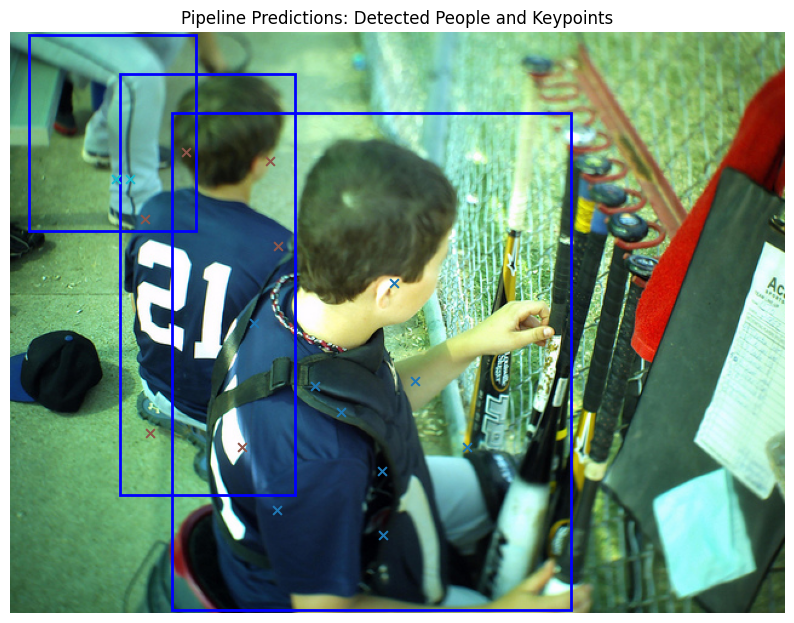

[{'box': [133, 67, 463, 477], 'keypoints': array([[345.97949219, 208.95933533,   0.        ],
       [328.48077393, 188.72267151,   0.        ],
       [347.54452515, 196.74320984,   0.        ],
       [261.35894775, 185.80206299,   0.        ],
       [316.40936279, 207.32461548,   1.        ],
       [201.07217407, 239.88723755,   1.        ],
       [272.78494263, 313.3107605 ,   1.        ],
       [251.70077515, 291.93890381,   1.        ],
       [307.72164917, 414.81008911,   1.        ],
       [333.69018555, 288.04214478,   1.        ],
       [376.63861084, 342.3527832 ,   1.        ],
       [219.6190033 , 394.7225647 ,   1.        ],
       [267.73114014, 435.56539917,   0.        ],
       [307.01635742, 362.19366455,   1.        ],
       [343.36856079, 415.6164856 ,   0.        ],
       [291.5123291 , 402.52053833,   0.        ],
       [303.85671997, 445.47973633,   0.        ]])}, {'box': [90, 34, 235, 382], 'keypoints': array([[186.63972473, 115.72029114,   0.      

In [40]:
loaded_pipeline = torch.load("../../models/keypoints_model_pipeline.pth", map_location=device, weights_only=False)

random_img_path = os.path.join(IMG_DIR_VAL, random.choice(os.listdir(IMG_DIR_VAL)))
random_img = Image.open(random_img_path).convert('RGB')

predictions = loaded_pipeline.predict(random_img)


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(random_img)
colors = plt.cm.get_cmap('tab10', len(predictions))
for person in predictions:
    x1, y1, x2, y2 = person['box']
    kps = person['keypoints']

    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='blue', linewidth=2)
    ax.add_patch(rect)

    # Assign a unique color for each person
    color = colors(predictions.index(person))
    for kp in kps:
        if kp[2] == 1:
            ax.scatter(kp[0], kp[1], color=color, marker='x', s=40)
ax.set_title("Pipeline Predictions: Detected People and Keypoints")
ax.axis('off')
plt.show()


print(predictions)